<h1>Musical analysis</h1>


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

%matplotlib inline

from fractal_julia import AudioAnalyzer 

audio_file = "music\TheMysteryoftheYetiPart2_track3.wav"
analyzer = AudioAnalyzer(audio_file)

We save the following data from the audio file:
- y - discrete audio signal (audio file is represented as real numbers in a N - dimensional array)
- sr - sampling rate (Hz) 
- duration - computed as $\frac{|y|}{sr}$
- hop - determines the time grid (sampling the signal in time blocks)
- RMS (energy or volume) - this approximates loudness
- spectrogram - visualization of FT
- onset envelope - measures how much the energy of the signal is changing over time 

In [27]:
print(f"Duration: {analyzer.duration:.2f} seconds")
print(f"Sample rate: {analyzer.sr} Hz")
print(f"Number of RMS frames: {len(analyzer.rms)}")

Duration: 913.00 seconds
Sample rate: 48000 Hz
Number of RMS frames: 85594


<h2>RMS</h2>

RMS approximates loudness and is computed over short time windows/frames. 

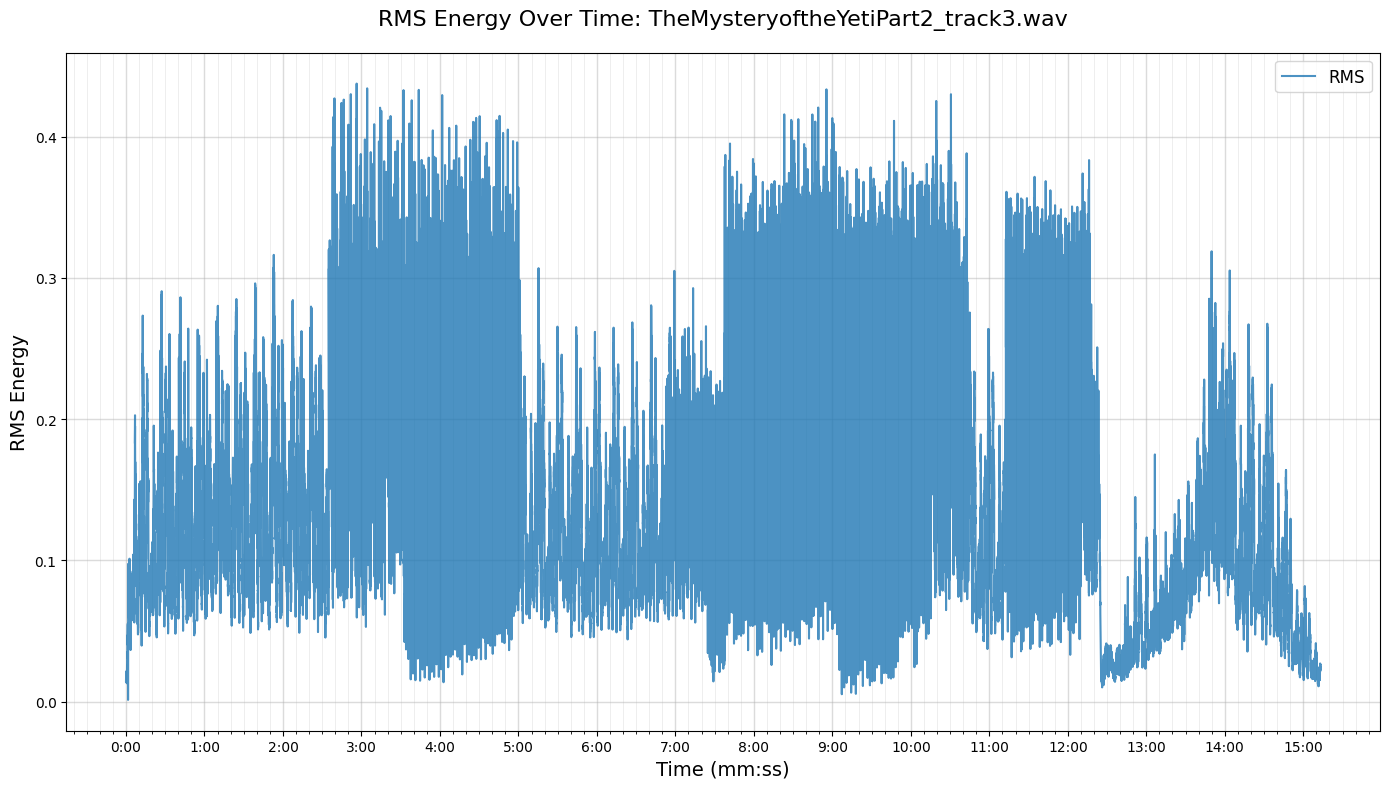

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter


time_rms = np.arange(len(analyzer.rms)) * analyzer.hop / analyzer.sr

def mmss(x, pos):
    m = int(x // 60)
    s = int(x % 60)
    return f"{m}:{s:02d}"


fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(
    time_rms,
    analyzer.rms,
    linewidth=1.5,
    alpha=0.8,
    label="RMS"
)


ax.xaxis.set_major_locator(MultipleLocator(60))   # 1 minute
ax.xaxis.set_minor_locator(MultipleLocator(10))   # 10 seconds
ax.xaxis.set_major_formatter(FuncFormatter(mmss))

ax.set_xlabel("Time (mm:ss)", fontsize=14)
ax.set_ylabel("RMS Energy", fontsize=14)
ax.set_title(
    f"RMS Energy Over Time: {os.path.basename(audio_file)}",
    fontsize=16,
    pad=20
)

ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)

ax.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()


<h2>Spectrogram</h2>
A spectrogram is a way to visualize how the energy of different 
frequency components in a sound signal changes over time.

- We take short overlapping blocks of the audio signal and compute a Fourier
  transform (STFT) for each block.
- Each Fourier transform gives us the amplitude of all frequencies in that block.
- The spectrogram is the collection of these amplitudes over time: a 2D array
  where rows correspond to frequencies, and columns correspond to time frames.
- By averaging over frequency ranges (low, mid, high), we can extract features
  that represent the energy in those bands at each moment.

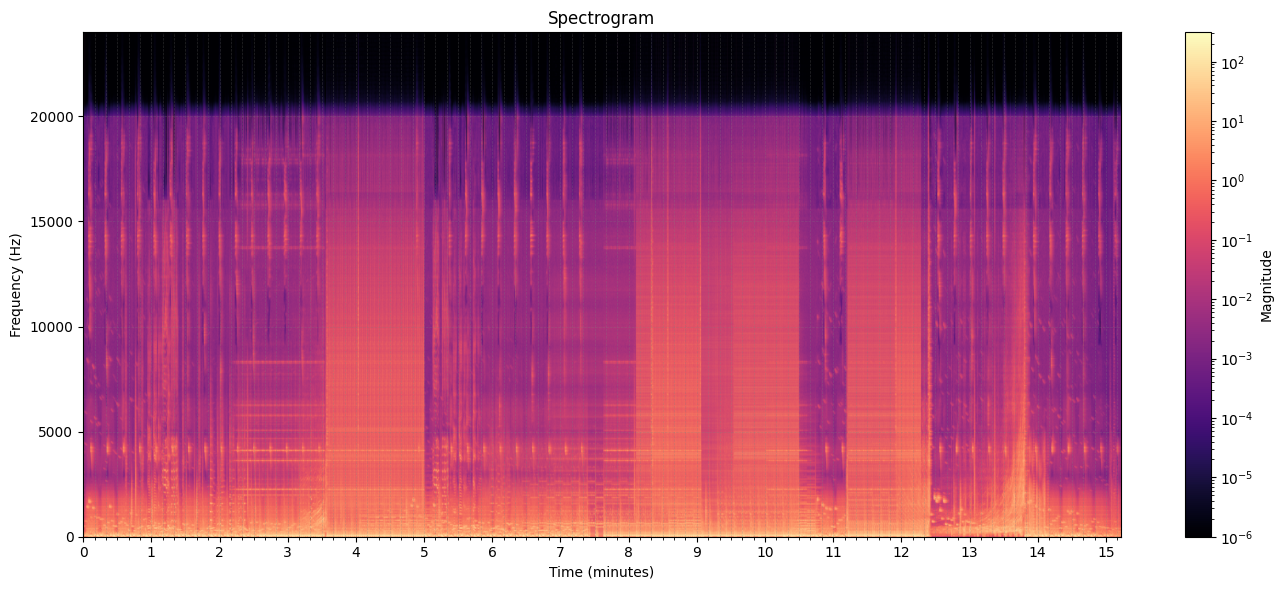

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from matplotlib.colors import LogNorm

def plot_spectrogram(analyzer):
    spec = analyzer.spec
    freqs = analyzer.freqs
    times_sec = np.arange(spec.shape[1]) * analyzer.hop / analyzer.sr
    times_min = times_sec / 60.0  # convert to minutes

    fig, ax = plt.subplots(figsize=(14, 6))

    # plot log-scaled amplitude for better visibility
    im = ax.imshow(
        spec,
        origin='lower',
        aspect='auto',
        extent=[times_min[0], times_min[-1], freqs[0], freqs[-1]],
        norm=LogNorm(vmin=1e-6, vmax=spec.max()),
        cmap='magma'
    )

    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Spectrogram')

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(1/6))

    fig.colorbar(im, ax=ax, label='Magnitude')
    ax.grid(which='both', color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_spectrogram(analyzer)




Reading a spectogram (visualization of Fourier Transform):
- **x-axis: time**: major ticks = 1 minute, minor ticks = 10 seconds.
- **y-axis: frequency**: Low notes are at the bottom (low frequency), high notes at the top (high frequency).
- **Color / brightness**: represents amplitude (volume or energy) at that frequency and time.

We can interpret darker areas as having low energy and brighter areas as having high energy.

Interpretation:

1. **Horizontal lines** - sustained notes or bass lines over the entierty of the track.  
2. **Vertical spikes** - sudden sounds or percussive hits .  
3. **Dense bright areas** - high-energy or fast sections.  
4. **Sparse dark areas** - calm or quiet sections.  
5. **Shifts in color from blue/purple → yellow/orange/red** - music getting louder or more “intense”.  


<h2>Onset envelope </h2>
The onset envelope detects "kicks": it tells you when the music suddenly jumps in energy.
Each value corresponds in the array to a short window in time.
Brighter/more positive values = strong events.


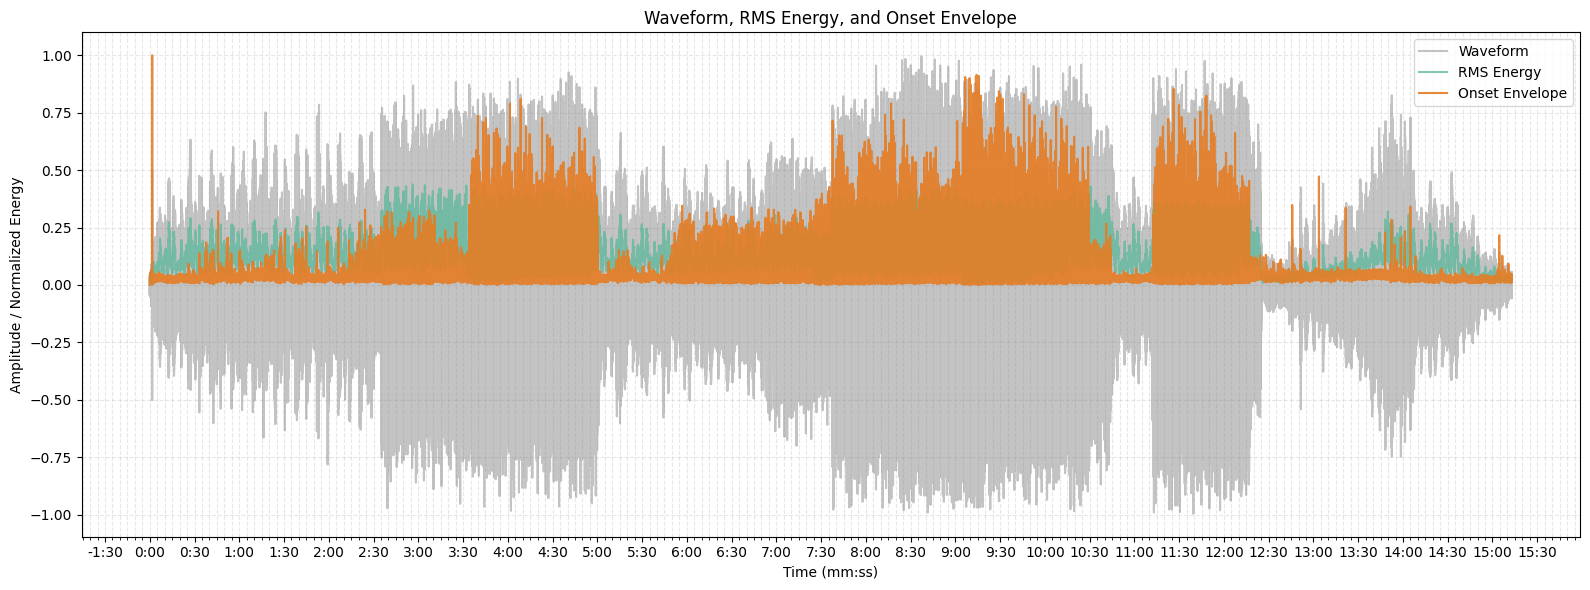

In [39]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

def plot_waveform_rms_onset(analyzer, start_sec=0, end_sec=None):
    y = analyzer.y
    sr = analyzer.sr
    hop = analyzer.hop
    rms = analyzer.rms
    onset = analyzer.onset_env

    # Determine frame range
    total_duration = len(y) / sr
    end_sec = end_sec if end_sec is not None else total_duration
    start_sample = int(start_sec * sr)
    end_sample = int(end_sec * sr)
    
    # Time axis for waveform
    t_wave = np.arange(start_sample, end_sample) / sr
    y_seg = y[start_sample:end_sample]

    # Time axis for RMS and onset
    start_frame = int(start_sec * sr / hop)
    end_frame = int(end_sec * sr / hop)
    t_feat = np.arange(start_frame, end_frame) * hop / sr
    rms_seg = rms[start_frame:end_frame]
    onset_seg = onset[start_frame:end_frame]


    fig, ax = plt.subplots(figsize=(16, 6))

    # Waveform
    ax.plot(t_wave, y_seg, color="#888888", alpha=0.5, label="Waveform")

    # RMS
    ax.plot(t_feat, rms_seg, color="#61B89D", linewidth=1.5, alpha=0.8, label="RMS Energy")

    # Onset envelope
    ax.plot(t_feat, onset_seg, color="#E57C23", linewidth=1.5, alpha=0.9, label="Onset Envelope")

    # X-axis in minutes:seconds
    def mmss(x, pos):
        m = int(x // 60)
        s = int(x % 60)
        return f"{m}:{s:02d}"
    ax.xaxis.set_major_formatter(FuncFormatter(mmss))
    ax.xaxis.set_major_locator(MultipleLocator(30))  # major tick every 30 seconds
    ax.xaxis.set_minor_locator(MultipleLocator(5))   # minor tick every 5 seconds

    ax.set_xlabel("Time (mm:ss)")
    ax.set_ylabel("Amplitude / Normalized Energy")
    ax.set_title("Waveform, RMS Energy, and Onset Envelope")
    ax.legend(loc="upper right")
    ax.grid(which="both", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_waveform_rms_onset(analyzer)

<h2>Beat tracking </h2>

Tempo - estimated BPM (is usually roughly constant across a single track in psytrace genre).

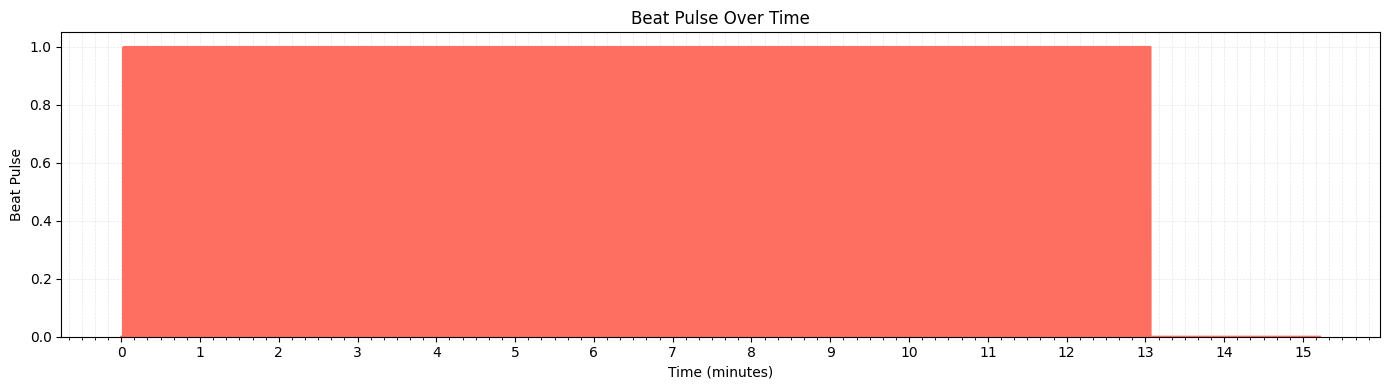

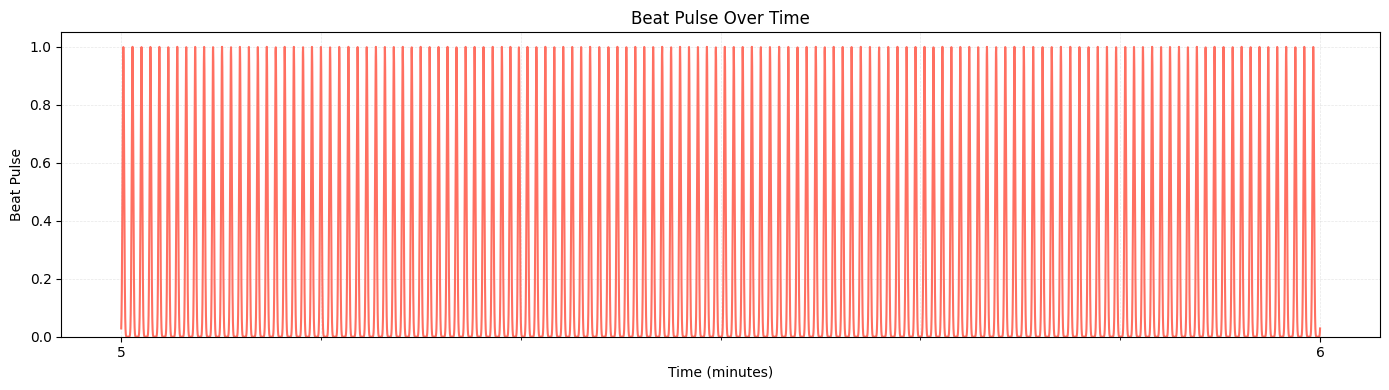

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

def plot_beat_pulse(analyzer, sigma=0.040, fps=200, start=None, end=None):
    """
    Plots the beat pulse over time for a segment of the track.
    
    analyzer : AudioAnalyzer instance
    sigma    : width of the Gaussian pulse in seconds
    fps      : how many samples per second to plot (higher = smoother)
    start    : start time in seconds (default 0)
    end      : end time in seconds (default analyzer.duration)
    """
    # Set start/end defaults
    if start is None:
        start = 0.0
    if end is None:
        end = analyzer.duration

    # Clip to valid range
    start = max(0.0, start)
    end = min(analyzer.duration, end)
    if end <= start:
        raise ValueError("End time must be greater than start time.")

    # Time array for the segment
    times = np.linspace(start, end, int((end - start) * fps))
    pulses = np.array([analyzer.beat_pulse(t, sigma=sigma) for t in times])

    # Convert x-axis to minutes
    times_min = times / 60.0

    # Plot
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(times_min, pulses, color="#FF6F61", linewidth=1.5)
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Beat Pulse")
    ax.set_title("Beat Pulse Over Time")
    ax.set_ylim(0, 1.05)

    # Major ticks every minute, minor ticks every 10 seconds
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(1/6))

    ax.grid(which='both', alpha=0.3, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# Plot the entire track
plot_beat_pulse(analyzer)

# Plot from 30s to 90s
plot_beat_pulse(analyzer, start=300, end=360)

Lastnosti, ki jih vrne funkcija

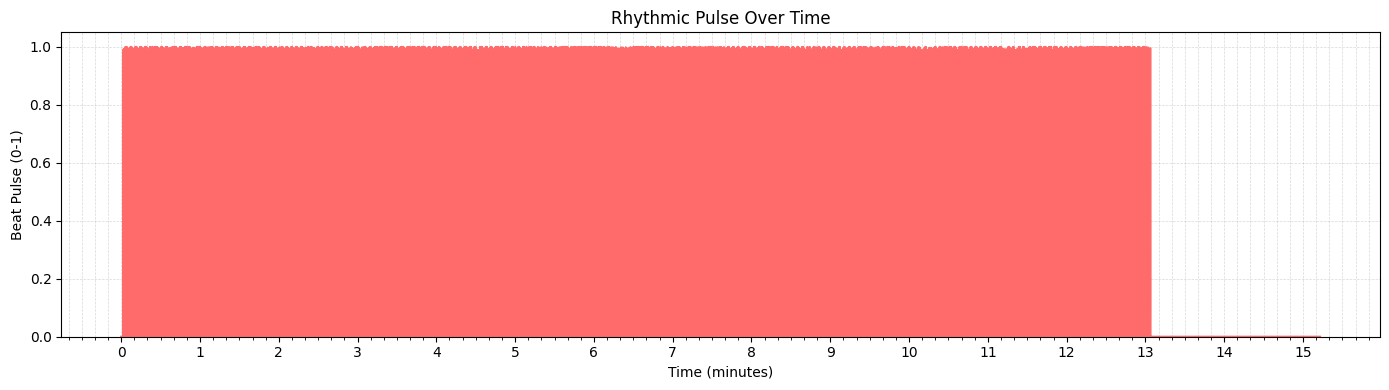

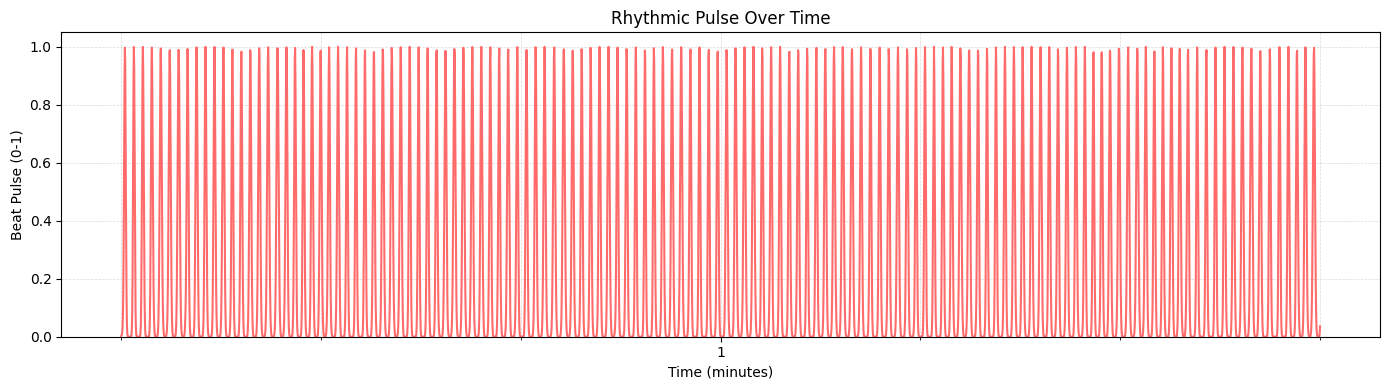

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

def plot_pulse(analyzer, fps=60, start=None, end=None):
    """
    Plot the rhythm-driven beat pulse over a segment of the track.
    
    analyzer : AudioAnalyzer instance
    fps      : how many samples per second to plot (higher = smoother)
    start    : start time in seconds (default 0)
    end      : end time in seconds (default analyzer.duration)
    """
    # Set defaults
    if start is None:
        start = 0.0
    if end is None:
        end = analyzer.duration

    # Clip to valid range
    start = max(0.0, start)
    end = min(analyzer.duration, end)
    if end <= start:
        raise ValueError("End time must be greater than start time.")

    # Time array for the segment
    total_frames = int(np.ceil((end - start) * fps))
    times_sec = np.linspace(start, end, total_frames)
    pulse_vals = np.array([analyzer.features_at(t)["pulse"] for t in times_sec])

    # Convert to minutes
    times_min = times_sec / 60.0

    # Plot
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(times_min, pulse_vals, color="#FF6B6B", linewidth=1.5)
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Beat Pulse (0-1)")
    ax.set_title("Rhythmic Pulse Over Time")
    ax.set_ylim(0, 1.05)

    # Major ticks: every 1 minute
    ax.xaxis.set_major_locator(MultipleLocator(1))
    # Minor ticks: every 10 seconds (~0.167 min)
    ax.xaxis.set_minor_locator(MultipleLocator(1/6))

    ax.grid(which='both', color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# Plot the entire track
plot_pulse(analyzer)

# Plot a segment from 30s to 90s
plot_pulse(analyzer, start=30, end=90)

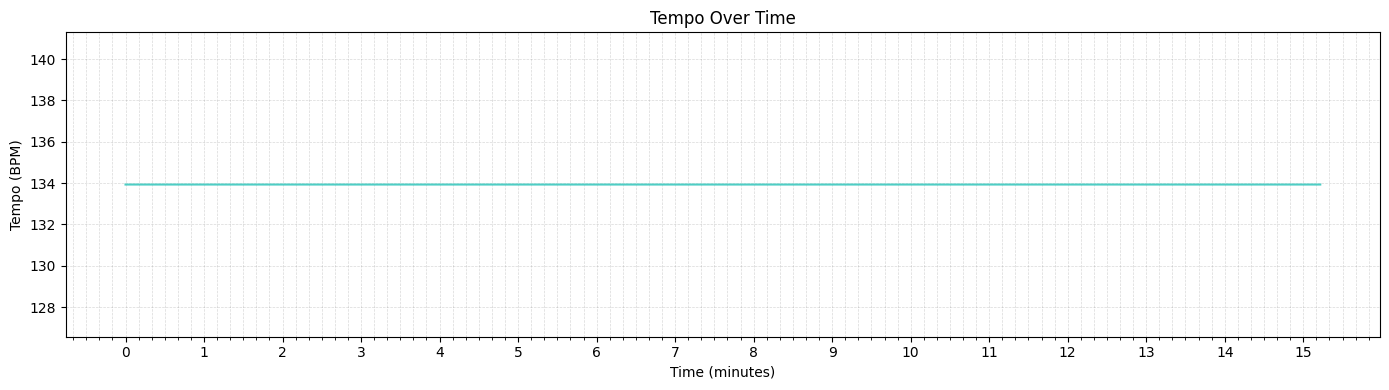

In [35]:
def plot_tempo(analyzer, fps=60):
    """Plot the tempo (BPM) over the track."""
    total_frames = int(np.ceil(analyzer.duration * fps))
    times_sec = np.arange(total_frames) / fps
    tempo_vals = np.array([analyzer.features_at(t)["tempo"] for t in times_sec])

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(times_sec / 60.0, tempo_vals, color="#4ECDC4", linewidth=1.5)
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Tempo (BPM)")
    ax.set_title("Tempo Over Time")

    # Major ticks: every 1 minute
    ax.xaxis.set_major_locator(MultipleLocator(1))
    # Minor ticks: 10-second intervals (~0.167 min)
    ax.xaxis.set_minor_locator(MultipleLocator(1/6))

    ax.grid(which='both', color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_tempo(analyzer)